In [1]:
import numpy as np
from bold_deconvolution import ridge_regress_deconvolution, compute_xb_Hxb
from scipy import io
from scipy.stats import pearsonr, gamma
from scipy.signal import detrend
import matplotlib.pyplot as plt

# Load example data

In [2]:
# Select example data below

In [3]:
data = io.loadmat('./example_data/01_Simulated_Block_Design_[TR_2s]_[NT_16].mat')
BOLD = data['preproc_BOLD_signal']
spm_neuro = data['spm_phys_neuro'].squeeze()
TR = 2          # Time repetition = 2 s
NT = 16         # Microtime resolution = 16

In [4]:
data = io.loadmat('./example_data/02_Simulated_Event_Related_Design_[TR_2s]_[NT_16].mat')
BOLD = data['preproc_BOLD_signal']
spm_neuro = data['spm_phys_neuro'].squeeze()
TR = 2          # Time repetition = 2 s
NT = 16         # Microtime resolution = 16

In [5]:
data = io.loadmat('./example_data/03_Empirical_Block_Design_[TR_720ms]_[NT_16].mat')
BOLD = data['preproc_BOLD_signal']
spm_neuro = data['spm_phys_neuro'].squeeze()
TR = 0.72       # Time repetition = 720 ms
NT = 16         # Microtime resolution = 16

In [6]:
data = io.loadmat('./example_data/04_Empirical_Event_Related_Design_[TR_2s]_[NT_34].mat')
BOLD = data['preproc_BOLD_signal']
spm_neuro = data['spm_phys_neuro'].squeeze()
TR = 2          # Time repetition = 2 s
NT = 34         # Microtime resolution = 34

In [4]:
# Plot data

Text(0.5, 0, 'Time points (TR = 2 s)')

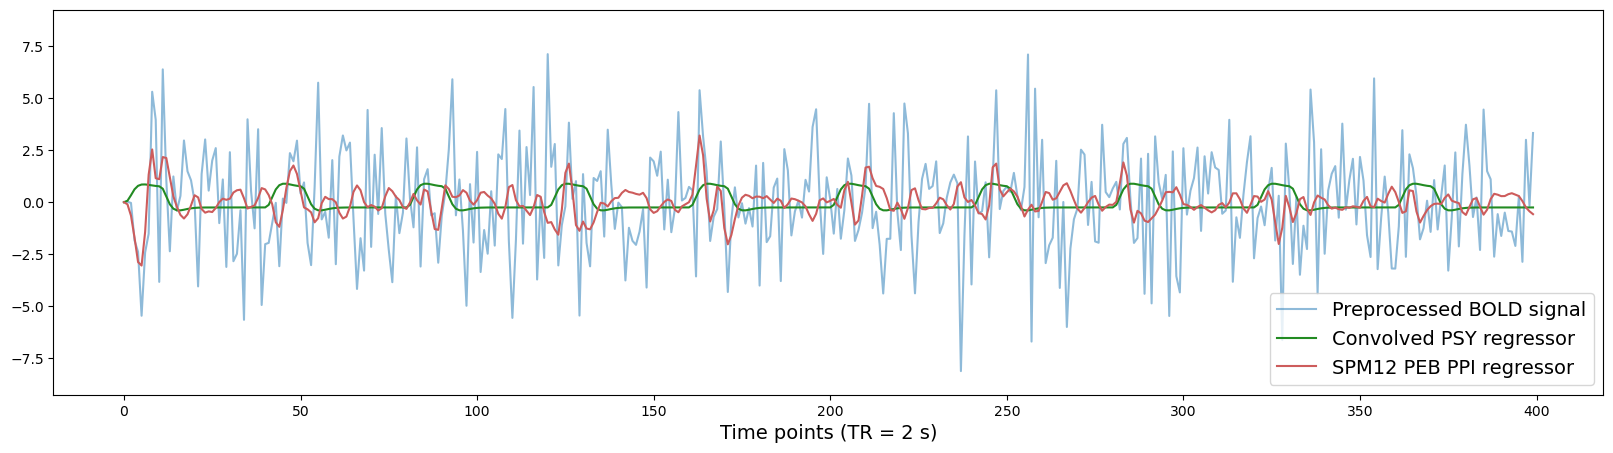

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(BOLD, label='Preprocessed BOLD signal', alpha=0.5)
plt.plot(data['psy_convolved'], c='forestgreen', label='Convolved PSY regressor')
plt.plot(data['spm_ppi'], c='indianred', label='SPM12 PEB PPI regressor')
plt.legend(fontsize=14)
plt.ylim(-1.3 * np.max(data['preproc_BOLD_signal']), 1.3 * np.max(data['preproc_BOLD_signal']))
plt.xlabel(f'Time points (TR = {TR} s)', fontsize=14)

# Recover neuronal signal using ridge regression

Text(5760.0, 7.458723359176885, 'r = 0.9992')

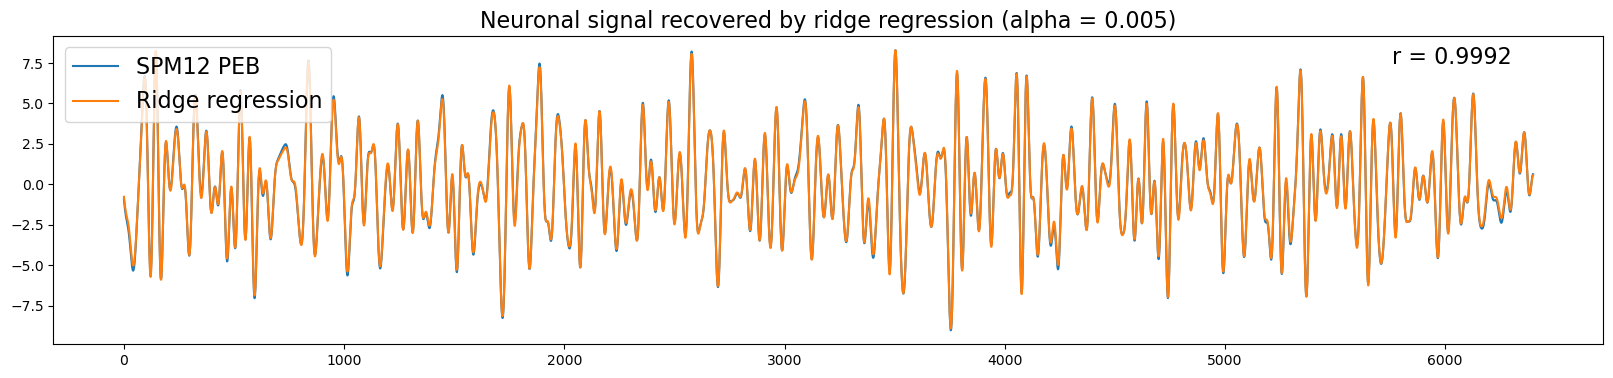

In [6]:
alpha = 0.005
neuronal = ridge_regress_deconvolution(BOLD, TR, alpha, NT)

plt.figure(figsize=(20, 4))
plt.title(f'Neuronal signal recovered by ridge regression (alpha = {alpha})',
                  fontsize=16)
plt.plot(spm_neuro, label='SPM12 PEB')
plt.plot(neuronal / np.max(neuronal) * np.max(spm_neuro), label='Ridge regression')
plt.legend(loc=2, fontsize=16)
r = pearsonr(neuronal, spm_neuro).correlation
plt.text(len(neuronal)* 0.9, np.max(spm_neuro) * 0.9, 'r = ' + str(round(r, 4)), fontsize=16)

# Calculate psycho-physiological interaction (PPI)

In [7]:
psy_neuro = data['psy_neuro'].squeeze()
psy_neuro_detrended = detrend(psy_neuro,axis = 0, type = 'constant')  # mean centering of the psychological (task) regressor prior to PPI term calculation
ppi_neuro = neuronal * psy_neuro_detrended

In [8]:
# Create canonical HRF in microtime resolution (identical to SPM12 cHRF)
dt = TR / NT
t = np.arange(0, 32 + dt, dt)
hrf = gamma.pdf(t, 6) - gamma.pdf(t, NT) / 6
hrf = hrf / np.sum(hrf)

In [9]:
# Convolve neuronal PPI
ppi_conv = np.convolve(ppi_neuro, hrf)[1:len(BOLD)*NT:NT]

Text(0.5, 0, 'Time points (TR = 2 s)')

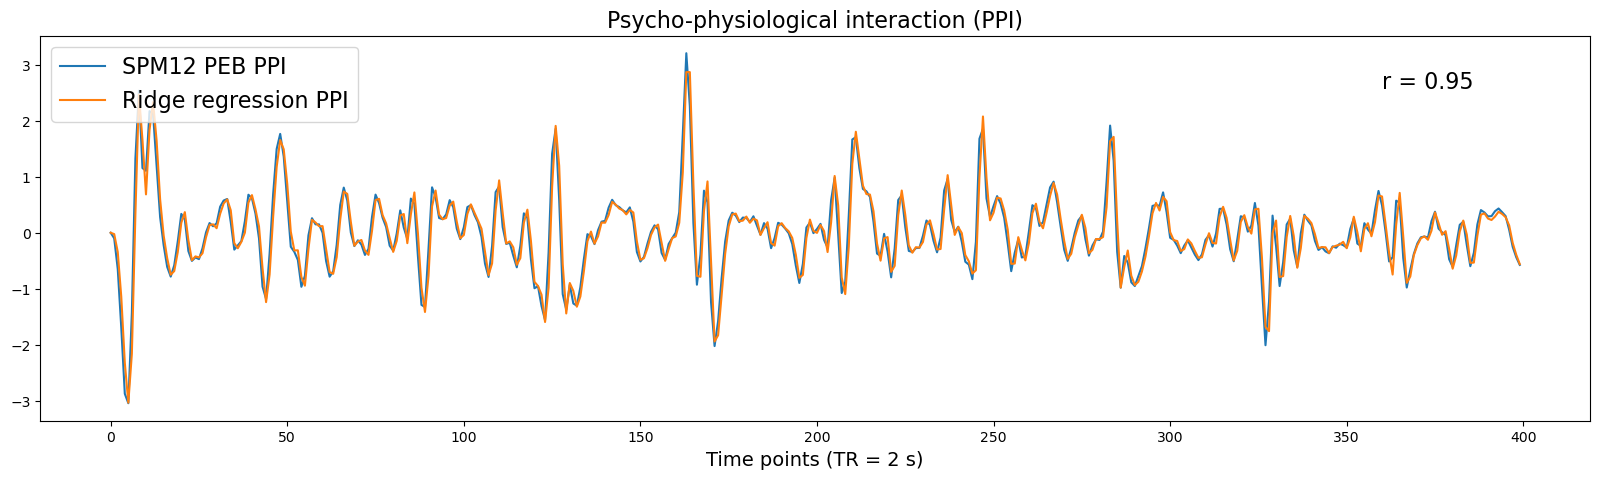

In [12]:
plt.figure(figsize=(20, 5))
plt.title(f'Psycho-physiological interaction (PPI)',
                  fontsize=16)
plt.plot(data['spm_ppi'], label='SPM12 PEB PPI')
plt.plot(ppi_conv, label='Ridge regression PPI')
plt.legend(loc=2, fontsize=16)
r = pearsonr(data['spm_ppi'][:,0], ppi_conv).correlation
plt.text(len(ppi_conv)* 0.9, np.max(ppi_conv) * 0.9, 'r = ' + str(round(r, 2)), fontsize=16)
plt.xlabel(f'Time points (TR = {TR} s)', fontsize=14)